# Exploring Residential House Prices in Singapore
By: Chengyi (Jeff) Chen

In this project, we will first gather a dataset of Singapore Residential housing prices and their features from [99.co](https://www.99.co/singapore), a popular online marketplace for property in Singapore. Afterwards, we will explore the data we've scraped using the CRISP-DM process.

---
## Table of Contents

1. [Transform Part 2](#transform)
2. [Load](#load)

In [1]:
# General Utilities for Web Scraping
import sys
import os
from os import listdir
from os.path import isfile, join, isdir
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import date, datetime, timedelta
from dateutil import relativedelta
import csv
import json
from collections import defaultdict
from collections import Counter

# Machine Learning Utitilies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Url
base_url = 'https://www.99.co/singapore/sale'

<a id='transform'></a>

---
# Transform Part 2

We'll now impute the remaining missing values for our data.

In [2]:
raw_final_dataset = pd.read_csv('./data/99.co/raw_final_dataset_{}.csv'.format(date.today().strftime("%Y_%m_%d")), index_col=[0])

In [3]:
raw_final_dataset.head()

,Availability,Condition,Cost of Renovation,District,Facing,Floor,Furnishing,Landed House Area Zoning,Last Renovated Date,Re-wiring/Structural Renovation,...,primary,secondary,sqft,tenure,total_units,transit_duration_to_changi_airport,transit_duration_to_orchard_road,transit_duration_to_raffles_place,type,year_since_completion
0,Now,NaN,NaN,D22,North South,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,506.0,99 Years,NaN,93.0,50.0,43.0,hdb,NaN
1,14 Feb 2023,NaN,NaN,D19,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,872.0,99 Years,1478.0,54.0,43.0,42.0,condo,-5.0
2,NaN,NaN,NaN,D28,NaN,NaN,Fully Furnished,NaN,NaN,NaN,...,4.0,1.0,689.0,99 Years,555.0,49.0,44.0,44.0,condo,2.0
3,Now,NaN,NaN,D05,North,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,882.0,NaN,NaN,86.0,41.0,38.0,hdb,NaN
4,Now,NaN,NaN,D11,South West,5,Fully Furnished,NaN,NaN,NaN,...,1.0,NaN,1615.0,Freehold,128.0,58.0,14.0,20.0,condo,7.0


In [4]:
# What features we are working with
raw_final_dataset.columns

Index(['Availability', 'Condition', 'Cost of Renovation', 'District', 'Facing',
       'Floor', 'Furnishing', 'Landed House Area Zoning',
       'Last Renovated Date', 'Re-wiring/Structural Renovation',
       'Tenancy Current Rent', 'Tenancy Lease Expiry', 'ammenities',
       'atm_nearby', 'average_transit_duration_to_subway',
       'average_transit_duration_to_supermarket',
       'average_walking_duration_to_bus_station',
       'average_walking_duration_to_clinic', 'link', 'num_baths', 'num_beds',
       'num_bus_stations_nearby', 'num_clinics_nearby', 'num_subways_nearby',
       'num_supermarkets_nearby', 'others', 'park_nearby', 'post_box_nearby',
       'post_office_nearby', 'pre-tertiary', 'price', 'primary', 'secondary',
       'sqft', 'tenure', 'total_units', 'transit_duration_to_changi_airport',
       'transit_duration_to_orchard_road', 'transit_duration_to_raffles_place',
       'type', 'year_since_completion'],
      dtype='object')

In [5]:
raw_final_dataset.shape

(9953, 41)

## A look at the Missing Data

We'll go through each feature column and take a look at how we should impute the values and whether we should just drop the entire feature column.

### Endogenous Variable: `price`

In [6]:
raw_final_dataset['price'].describe()

count    9.840000e+03
mean     2.569126e+06
std      4.379227e+07
min      1.880000e+05
25%      6.777500e+05
50%      1.185000e+06
75%      2.035795e+06
max      3.850000e+09
Name: price, dtype: float64

Without the `price`, we can't really do anything in terms of regression later on. Hence, I'd suggest dropping all the observations that don't have `price`.

In [7]:
# Remove observations with no price
raw_final_dataset = raw_final_dataset[raw_final_dataset['price'].astype(str) != 'nan']

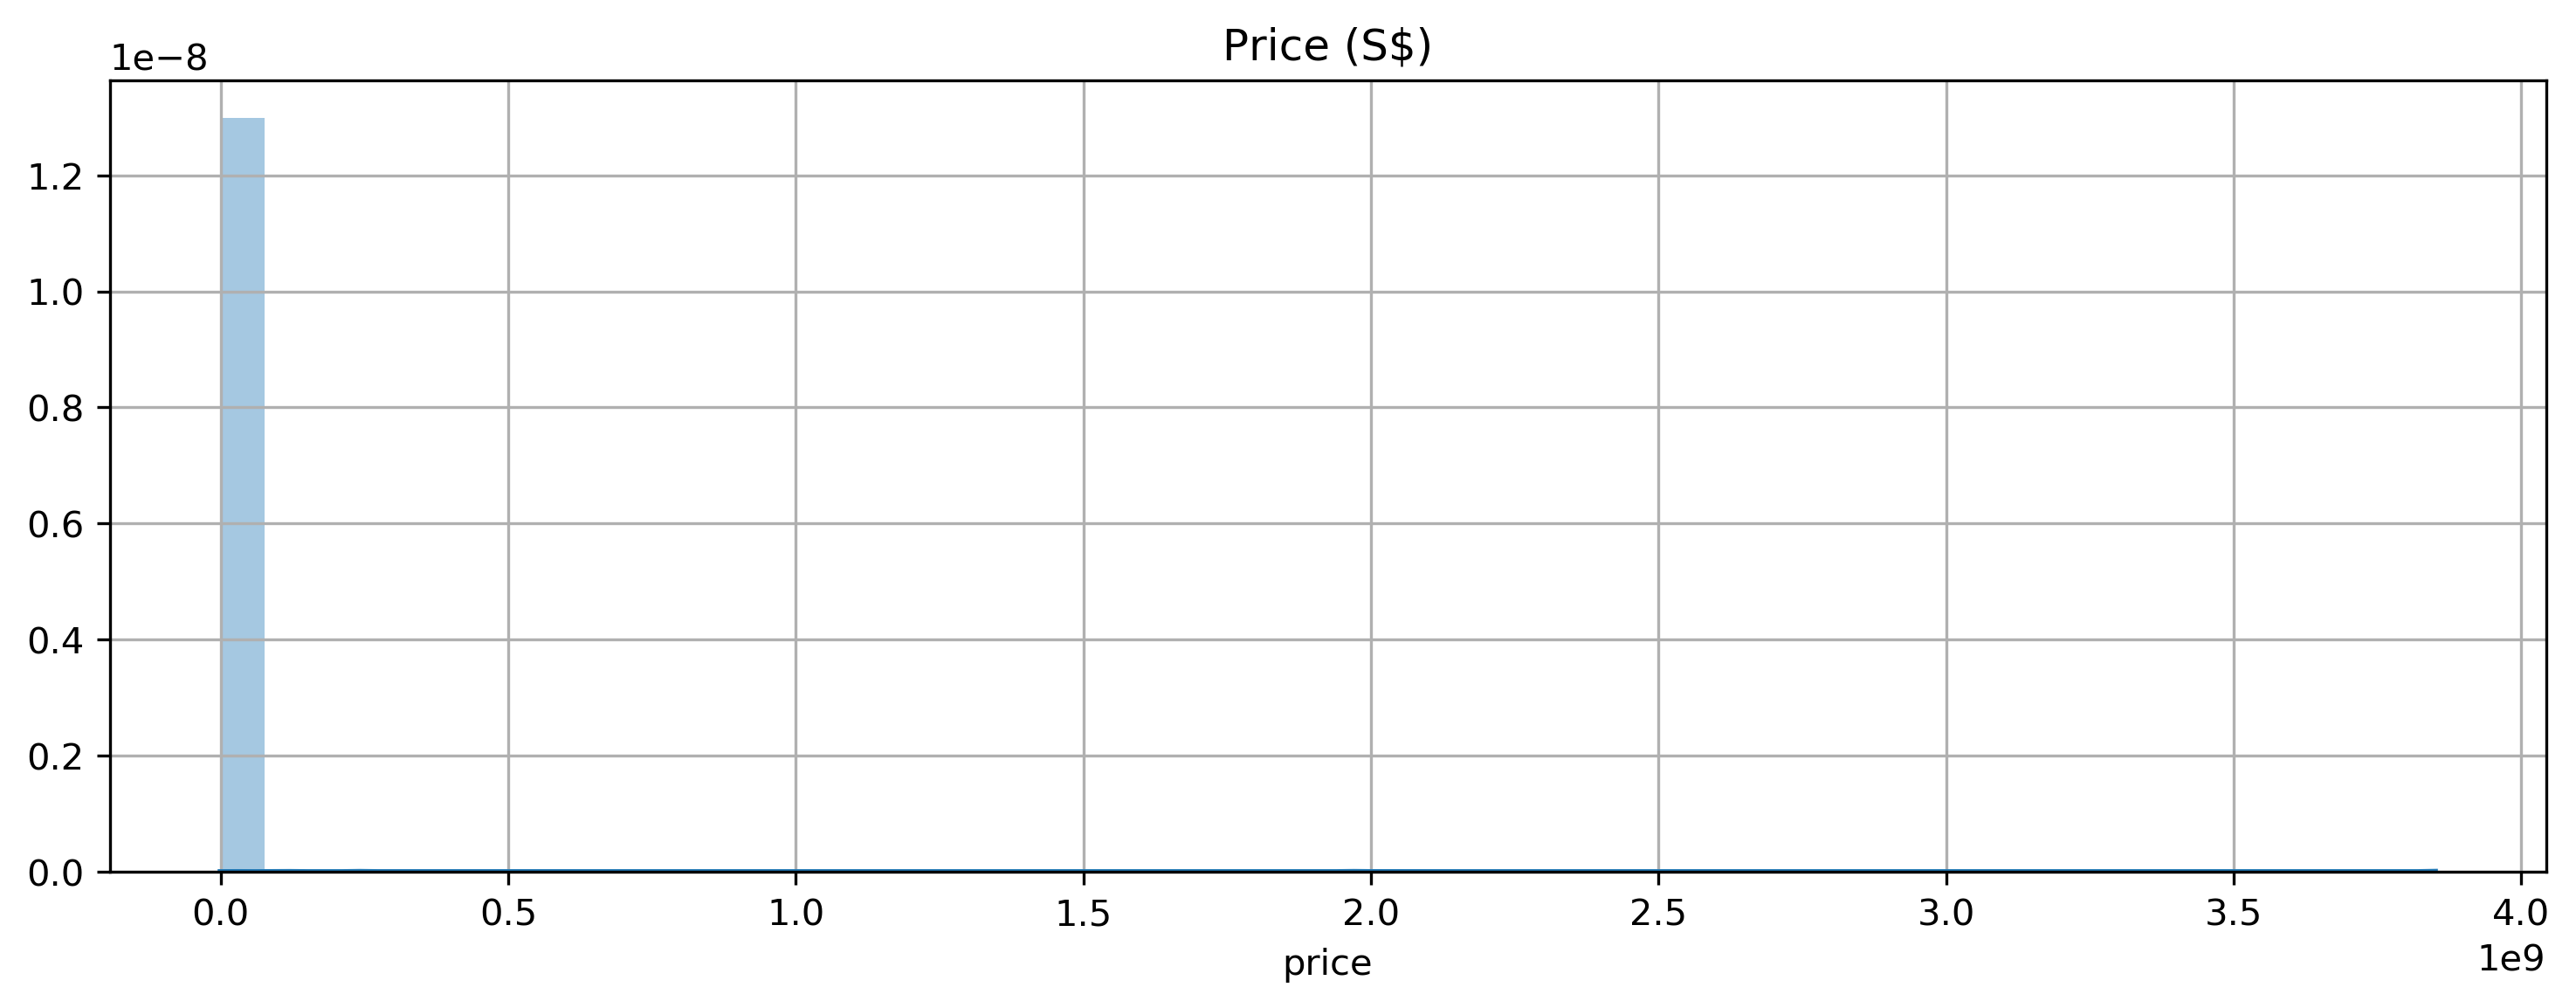

In [8]:
# A look at the distribution of prices
plt.figure(figsize=(12, 4), dpi=300)
sns.distplot(raw_final_dataset['price'])
plt.title('Price (S$)')
plt.grid();

### Exogenous Variables / Features

In [9]:
# Stores the categorical features in a list
cat_feats = []

# Stores numerical features in a list
num_feats = []

### 1. Categorical:  `Availability`

In [10]:
cat_feats.append('Availability')
raw_final_dataset['Availability'].describe()

count     8304
unique     362
top        Now
freq      7115
Name: Availability, dtype: object

In [11]:
raw_final_dataset['Availability'].value_counts()

Now            7115
01 Jan 2022      60
31 Dec 2024      38
01 Aug 2019      35
01 Jun 2022      23
31 Dec 2022      23
31 Dec 2023      21
01 Sep 2019      21
31 Dec 2019      19
31 Jul 2019      19
01 Oct 2022      17
31 Aug 2019      17
30 Sep 2019      15
01 Dec 2024      14
30 Sep 2022      13
13 Jul 2019      13
30 Jun 2022      13
01 Oct 2019      13
31 Aug 2022      12
31 Dec 2021      12
01 Jan 2023      12
01 Jan 2024      11
12 Jul 2019      11
31 Jul 2022      11
15 Jul 2019      11
01 Aug 2022      11
01 Nov 2019      11
01 Feb 2020      10
01 Oct 2023      10
30 Sep 2023      10
               ... 
17 Apr 2020       1
12 Oct 2019       1
03 Feb 2020       1
20 Jun 2020       1
06 Sep 2019       1
18 May 2020       1
05 Feb 2021       1
17 Aug 2020       1
24 Jan 2021       1
23 Dec 2020       1
17 Dec 2020       1
11 Oct 2019       1
03 May 2023       1
16 Jul 2019       1
21 Apr 2021       1
14 Sep 2021       1
13 Dec 2019       1
12 Dec 2024       1
13 Feb 2020       1


We have a ton of NaNs in this feature column. It seems like only 5 properties are available right now, while the rest are all still occupied. We'll impute `occupied` to replace the NaNs.

In [12]:
raw_final_dataset['Availability'] = raw_final_dataset['Availability'].fillna('Occupied')
raw_final_dataset['Availability'].head()

0            Now
1    14 Feb 2023
2       Occupied
3            Now
4            Now
Name: Availability, dtype: object

### 2. Categorical: `Condition`

In [13]:
cat_feats.append('Condition')
raw_final_dataset['Condition'].describe()

count                181
unique                 3
top       For Reno / A&A
freq                  92
Name: Condition, dtype: object

In [14]:
raw_final_dataset['Condition'].value_counts()

For Reno / A&A                92
Brand New                     77
Land Only / For Rebuilding    12
Name: Condition, dtype: int64

Again, we have a large number of NaNs. Taking a look at the values available, I'll assume that any NaN means that the property was `Used`.

In [15]:
raw_final_dataset['Condition'] = raw_final_dataset['Condition'].fillna('Used')
raw_final_dataset['Condition'].head()

0    Used
1    Used
2    Used
3    Used
4    Used
Name: Condition, dtype: object

### 3. Numerical: `Cost of Renovation`

In [16]:
num_feats.append('Cost of Renovation')
raw_final_dataset['Cost of Renovation'].describe()

count           36
unique          16
top       S$300000
freq             8
Name: Cost of Renovation, dtype: object

In [17]:
raw_final_dataset['Cost of Renovation'].value_counts()

S$300000     8
S$500000     4
S$400000     3
S$1000000    3
S$0          3
S$50000      3
S$200000     2
S$350000     2
S$3800000    1
S$150000     1
S$250000     1
S$100000     1
S$750000     1
S$1800000    1
S$1500000    1
S$6000000    1
Name: Cost of Renovation, dtype: int64

Similarly, there are a lot of missing values here too. However, this isn't unexpected since not all properties require renovation. Hence, we'll impute `S$0.0` to replace the NaNs, strip the `S$` from each of the current values, and convert them into floats.

In [18]:
raw_final_dataset['Cost of Renovation'] = raw_final_dataset['Cost of Renovation'].fillna('S$0').apply(lambda value: float(value[2:]))
raw_final_dataset['Cost of Renovation'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Cost of Renovation, dtype: float64

### 4. Categorical: `District`

In [19]:
cat_feats.append('District')
raw_final_dataset['District'].describe()

count     9691
unique      30
top        D19
freq      1347
Name: District, dtype: object

In [20]:
raw_final_dataset['District'].value_counts()

D19    1347
D15     609
D18     600
D10     513
D09     503
D20     474
D23     468
D03     443
D14     396
D27     388
D16     363
D12     357
D05     338
D28     325
D22     305
D04     300
D25     269
D11     267
D13     260
D01     226
D02     198
D21     196
D08     135
D17     127
D07     102
D26      63
D9       42
D5       39
D3       26
D06      12
Name: District, dtype: int64

In contrast to the previous features, this has significantly fewer missing values. 
- However, filling in the missing values for this feature is tough because it depends completely on the exact location of the property since these "districts" are [designated by the Singapore Post](https://en.wikipedia.org/wiki/Postal_codes_in_Singapore). 
- Since we're not actually using this feature in the cluster analysis, it isn't too important for the Machine Learning model and we'll exclude it. However, we do need to validate whether the clusters created by our model matches these districts and so I've decided to drop the observations that are missing this value. 
- We'll still have to format the values properly though - there `D05` and `D5` are the same thing and it seems like the only district that is not represented is `D24`.

In [21]:
raw_final_dataset['District'] = raw_final_dataset['District'].apply(lambda value: 'D' + str(int(str(value)[1:])) if str(value) != 'nan' else None)
raw_final_dataset['District'].head()

0    D22
1    D19
2    D28
3     D5
4    D11
Name: District, dtype: object

In [22]:
# Drop observations missing this feature
raw_final_dataset = raw_final_dataset[~raw_final_dataset['District'].isna()]

### 5. Categorical: `Facing`

In [23]:
cat_feats.append('Facing')
raw_final_dataset['Facing'].describe()

count            4626
unique              9
top       North South
freq             1115
Name: Facing, dtype: object

In [24]:
raw_final_dataset['Facing'].value_counts()

North South    1115
North           985
South           643
North East      490
South East      454
East            308
South West      273
North West      261
West             97
Name: Facing, dtype: int64

We have a reasonable amount of missing values here. We'll leave the NaNs though, and when we one-hot encode later on, we'll just set 0s for all the properties that are missing a `Facing`.

### 6. Mixed: `Floor`

In [25]:
cat_feats.append('Floor')
raw_final_dataset['Floor'].describe()

count     765
unique     94
top        02
freq      109
Name: Floor, dtype: object

In [26]:
raw_final_dataset['Floor'].value_counts()[:20]

02    109
04     74
03     69
05     54
01     49
06     33
10     27
08     26
07     23
11     22
09     20
12     19
13     15
19     10
16      9
21      9
15      8
14      8
22      8
18      8
Name: Floor, dtype: int64

This feature's abit tricky since we have a mix of both strings, numerics, and strings with numerics. We have to do some smart processing here. 
- First, we'll check if the value contains any numerics at all. 
    - If it is a mix of numerics and words, we'll split the string to 2 parts - only words and only numerics. We'll first look at the words to see if they match any 'key terms' in a set of floor categories we'll set, e.g. low_floor {'low', 'ground'}, mid_floor {'mid'}, high_floor {'high'}, top_floor {'penthouse', 'top'}. If nothing matches, we'll default to using the numerics.
    - If the value does not contain any numerical information, we'll check if any words inside match the 'key terms' in our set of floor categories.
    - If the value is purely numeric, we'll limit the number of integers to 2 (assuming that we don't go up to >100 floors) and bin them into those categories, e.g. Floors 1 to 5 are low_floor, 6 to 10 are mid_floor.
- I do acknowledge that this imputation method does contain a lot of assumptions. Ideally, we would have the total number of floors available in each property's project to get a better gauge of whether it's a 'low' / 'mid' / 'high' / 'top' floor. But then again, the idea of these categories are also pretty subjective too. Comnparing a real estate project that contains 50 levels and one that contains 10 levels, both might be of the exact same height, making level 10 in the former to be a low floor whilst being a top floor in the latter. Hence, this is really the best we could do now unless we really want to dig into each property's dimensions and specific details later on.
- Also, there will still be missing values after this, but I'll deal with them later after we've finished going through each feature we're working with.

In [27]:
# Dictionary of all the terms associated with each bin
BIN_TERMS =  {
    'low': {'low', 'ground'},
    'mid': {'mid'},
    'high': {'high'},
    'top': {'top', 'penthouse'}
}

def clean_floors(value, bin_terms):
    """
    Purpose:
    --------
    Bins value into 1 of 4 categories, either `low_floor`, `mid_floor`, `high_floor`, or `top_floor`
    
    Parameters:
    -----------
    value: (str) A single value from the Pandas Series of floors
    
    Returns:
    --------
    Either `low_floor`, `mid_floor`, `high_floor`, or `top_floor`
    """
    def category(value, bin_terms):
        """
        Purpose:
        --------
        Checks if any term in value matches the 
        key terms for our floor bins

        Parameters:
        -----------
        value: (str) A single value from the Pandas Series of floors
        bin_terms: (dict) Dictionary of key: bin_names and value: (set) of key terms

        Returns:
        --------
        key of the bin_terms if any word in value matches the key 
        terms in the key terms of the bins
        """
        letters_and_special_chars = []
        numbers = []
        for char in value.lower():
            if char.isdigit():
                numbers.append(char)
            elif char != ' ':
                letters_and_special_chars.append(char)

        only_words = ''.join(letters_and_special_chars)

        for key, terms in bin_terms.items():
            for term in terms:
                if term in only_words:
                    return key
        else:
            return None
        
    def get_bin(number: int):
        """
        Purpose:
        --------
        Returns which floor bin category the number belongs to
        
        Parameters:
        -----------
        number: (int)
        
        Returns:
        --------
        Returns which floor bin category the number belongs to
        """
        if number < 6:
            return 'low'
        elif number >= 6 and number < 11:
            return 'mid'
        elif number >= 11 and number < 21:
            return 'high'
        else:
            return 'top'
        
    # Return None if value is None
    if value == None:
        return None
        
    # Check if category already exists in the value given
    cat = category(value, bin_terms)
    
    # Return the category if it's identified
    if cat:
        return cat
    # Check if 
    else:
        # Split on all the spaces so that we can 
        # handle things like the list of floors 7 8 9 10 11 12
        value_list = value.split()

        # Check if any are numeric
        for val in value_list:
            if val.strip().isdigit():
                return get_bin(int(val.strip()))

In [28]:
raw_final_dataset['Floor'] = raw_final_dataset['Floor'].apply(lambda value: clean_floors(str(value), BIN_TERMS))
raw_final_dataset['Floor'].head()

0    None
1    None
2    None
3    None
4     low
Name: Floor, dtype: object

### 7. Categorical: `Furnishing`

In [29]:
cat_feats.append('Furnishing')
raw_final_dataset['Furnishing'].describe()

count                    1347
unique                      4
top       Partially Furnished
freq                      852
Name: Furnishing, dtype: object

In [30]:
raw_final_dataset['Furnishing'].value_counts()

Partially Furnished    852
Unfurnished            268
Fully Furnished        223
Unknown                  4
Name: Furnishing, dtype: int64

Quite a number of missing data here. I'll make a wild assumption here that most houses that are on sale are currently occupied and so is furnished. However, once the deal closes, most of the existing furniture will be moved out in normal cases - hence, I'll impute missing values as `Partially Furnished`. Furthermore, it's also the most frequent category here.

In [31]:
raw_final_dataset['Furnishing'] = raw_final_dataset['Furnishing'].fillna(raw_final_dataset['Furnishing'].mode()[0])
raw_final_dataset['Furnishing'].head()

0    Partially Furnished
1    Partially Furnished
2        Fully Furnished
3    Partially Furnished
4        Fully Furnished
Name: Furnishing, dtype: object

### 8. Categorical: `Landed House Area Zoning`

In [32]:
cat_feats.append('Landed House Area Zoning')
raw_final_dataset['Landed House Area Zoning'].describe()

count                       657
unique                        9
top       3 Storey Mixed Landed
freq                        217
Name: Landed House Area Zoning, dtype: object

In [33]:
raw_final_dataset['Landed House Area Zoning'].value_counts()

3 Storey Mixed Landed         217
Others                        151
2 Storey Mixed Landed          82
3 Storey Semi D                56
2 Storey Semi D                45
Not in Landed Housing Area     41
2 Storey Bungalow              35
3 Storey Bungalow              22
GCBA                            8
Name: Landed House Area Zoning, dtype: int64

The large number of missing data here is not unexpected since it only applies for landed properties. We'll set all the missing values to `Not Applicable`.

In [34]:
raw_final_dataset['Landed House Area Zoning'] = raw_final_dataset['Landed House Area Zoning'].fillna('Not Applicable')
raw_final_dataset['Landed House Area Zoning'].head()

0    Not Applicable
1    Not Applicable
2    Not Applicable
3    Not Applicable
4    Not Applicable
Name: Landed House Area Zoning, dtype: object

### 9. Date: `Last Renovated Date`

In [35]:
num_feats.append('months_since_last_renovation')
raw_final_dataset['Last Renovated Date'].describe()

count              72
unique             63
top       19 Apr 2012
freq                7
Name: Last Renovated Date, dtype: object

In [36]:
raw_final_dataset['Last Renovated Date'].value_counts()[:20]

19 Apr 2012    7
01 Jan 2016    3
27 Oct 2018    2
01 Mar 2012    1
31 Aug 2017    1
05 Jan 1998    1
06 Jun 2012    1
01 Jan 2009    1
06 Dec 2018    1
28 Nov 2018    1
08 Dec 2013    1
01 Jun 2015    1
17 Mar 2009    1
01 Jan 2022    1
01 Jun 2017    1
06 Jun 2006    1
07 Aug 1990    1
05 Nov 2011    1
02 Sep 2012    1
24 Apr 2019    1
Name: Last Renovated Date, dtype: int64

Since this column contains dates and mostly nans, we'll convert this feature into one called `months_since_last_renovation`. We'll impute `0` months for the missing values.

In [37]:
def clean_last_renovated_date(value):
    """
    Purpose:
    --------
    Return the number of months since renovation from today's date
    
    Parameters:
    -----------
    value: (str) A date in this format - '%d %b %Y'
    
    Returns:
    --------
    Return the number of months since renovation from today's date
    """
    if str(value) == 'nan':
        return 0
    else:
        datetime_obj = datetime.strptime(str(value), '%d %b %Y')
        diff = relativedelta.relativedelta(date.today(), datetime_obj)
        return diff.years * 12 + diff.months

In [38]:
raw_final_dataset['months_since_last_renovation'] = raw_final_dataset['Last Renovated Date'].apply(lambda value: clean_last_renovated_date(value)).fillna(0)
raw_final_dataset.drop('Last Renovated Date', axis=1, inplace=True)
raw_final_dataset['months_since_last_renovation'].head()

0    0
1    0
2    0
3    0
4    0
Name: months_since_last_renovation, dtype: int64

### 10. Categorical: `Re-wiring/Structural Renovation`

In [39]:
cat_feats.append('Re-wiring/Structural Renovation')
raw_final_dataset['Re-wiring/Structural Renovation'].describe()

count     159
unique      2
top       Yes
freq       83
Name: Re-wiring/Structural Renovation, dtype: object

In [40]:
raw_final_dataset['Re-wiring/Structural Renovation'].value_counts()

Yes    83
No     76
Name: Re-wiring/Structural Renovation, dtype: int64

There are alot of missing values here. I'll make another assumption here that if no information was given about `Re-wiring/Structural Renovation`, it should be a `No`, so that's what we'll impute for missing values.

In [41]:
raw_final_dataset['Re-wiring/Structural Renovation'] = raw_final_dataset['Re-wiring/Structural Renovation'].fillna('No')
raw_final_dataset['Re-wiring/Structural Renovation'].head()

0    No
1    No
2    No
3    No
4    No
Name: Re-wiring/Structural Renovation, dtype: object

### 11. Numeric, Continuous: `Tenancy Current Rent`

In [42]:
raw_final_dataset['Tenancy Current Rent'].describe()

count        518
unique       108
top       S$2000
freq          28
Name: Tenancy Current Rent, dtype: object

In [43]:
raw_final_dataset['Tenancy Current Rent'].value_counts()[:20]

S$2000    28
S$3000    25
S$2200    20
S$0       18
S$3200    17
S$2100    17
S$4000    17
S$3800    16
S$2500    15
S$1800    15
S$2300    13
S$1850    12
S$2800    12
S$1900    12
S$3300    11
S$2600    11
S$3600    10
S$3500     9
S$4750     9
S$2700     9
Name: Tenancy Current Rent, dtype: int64

Since this encodes some information about the price of the house - the higher the rent, the higher the sale price of property, we'll exclude it from our final dataset.

In [44]:
raw_final_dataset.drop('Tenancy Current Rent', axis=1, inplace=True)

### 12. Date: `Tenancy Lease Expiry`

In [45]:
num_feats.append('months_before_tenancy_lease_expiry')
raw_final_dataset['Tenancy Lease Expiry'].describe()

count             963
unique            467
top       31 Dec 2019
freq               23
Name: Tenancy Lease Expiry, dtype: object

In [46]:
raw_final_dataset['Tenancy Lease Expiry'].value_counts()[:20]

31 Dec 2019    23
30 Nov 2019    19
30 Sep 2019    18
30 Jun 2019    17
30 Apr 2020    17
31 Jul 2019    16
31 May 2019    13
31 Jan 2019    12
31 Jan 2020    12
31 Oct 2019    11
31 Aug 2019    11
01 Feb 2020    10
01 Jul 2019    10
31 Mar 2020     9
01 Oct 2019     9
30 Apr 2019     8
30 Jun 2020     8
31 May 2020     7
01 Aug 2019     7
01 Jan 2020     6
Name: Tenancy Lease Expiry, dtype: int64

Similar to what we encountered with `Last Renovated Date`, we'll convert this feature to `months_before_tenancy_lease_expiry` and impute all missing values with `0` months.

In [47]:
def clean_tenancy_lease_expiry(value):
    """
    Purpose:
    --------
    Return the number of months before tenancy lease expires from today's date
    
    Parameters:
    -----------
    value: (str) A date in this format - '%d %b %Y'
    
    Returns:
    --------
    Return the number of months before tenancy lease expires from today's date
    """
    if str(value) == 'nan':
        return 0
    else:
        datetime_obj = datetime.strptime(str(value), '%d %b %Y')
        diff = relativedelta.relativedelta(date.today(), datetime_obj)
        return diff.years * 12 + diff.months

In [48]:
raw_final_dataset['months_before_tenancy_lease_expiry'] = raw_final_dataset['Tenancy Lease Expiry'].apply(lambda value: clean_tenancy_lease_expiry(value)).fillna(0)
raw_final_dataset.drop('Tenancy Lease Expiry', axis=1, inplace=True)
raw_final_dataset['months_before_tenancy_lease_expiry'].head()

0    0
1    0
2    0
3    0
4    5
Name: months_before_tenancy_lease_expiry, dtype: int64

### 13. Binary Features
- `atm_nearby`, `park_nearby`, `post_box_nearby`, `post_office_nearby`

In [49]:
for feat in ['atm_nearby', 'park_nearby', 'post_box_nearby', 'post_office_nearby']:
    print(raw_final_dataset[feat].value_counts())

1    7888
0    1803
Name: atm_nearby, dtype: int64
0    6575
1    3116
Name: park_nearby, dtype: int64
1    7859
0    1832
Name: post_box_nearby, dtype: int64
0    5003
1    4688
Name: post_office_nearby, dtype: int64


Since we already handled the imputations manually previously in the [Data Understanding](#data-understanding) section, we'll skip this.

### 14. Numeric, Continuous: Walking Duration
- `average_walking_duration_to_bus_station`, `average_walking_duration_to_clinic`

In [50]:
raw_final_dataset[['average_walking_duration_to_bus_station', 'average_walking_duration_to_clinic']].describe()

,average_walking_duration_to_bus_station,average_walking_duration_to_clinic
count,7824.000000,7291.000000
mean,4.669765,4.976816
std,0.842013,1.531873
min,2.500000,0.000000
25%,4.000000,4.000000
50%,4.600000,5.000000
75%,5.200000,6.000000
max,9.000000,11.000000


We said earlier in the [Data Understanding](#data-understanding) section that we'll impute the missing values for this with the max or something similar. I've decided to impute `2 * max` for the missing values.

In [51]:
fill_2max = lambda col: col.fillna(col.max() * 2) # Max function
raw_final_dataset[['average_walking_duration_to_bus_station', 
                   'average_walking_duration_to_clinic']] = raw_final_dataset[['average_walking_duration_to_bus_station', 
                                                                               'average_walking_duration_to_clinic']].apply(fill_2max, axis=0) # Fill all missing values with the 2*max of the column.

In [52]:
raw_final_dataset[['average_walking_duration_to_bus_station', 
                   'average_walking_duration_to_clinic']].describe()

,average_walking_duration_to_bus_station,average_walking_duration_to_clinic
count,9691.000000,9691.000000
mean,7.237874,9.192650
std,5.311643,7.467573
min,2.500000,0.000000
25%,4.200000,4.400000
50%,4.888889,5.500000
75%,6.000000,11.000000
max,18.000000,22.000000


### 15. Transit Duration
- `average_transit_duration_to_subway`, `average_transit_duration_to_supermarket`, `transit_duration_to_changi_airport`, `transit_duration_to_orchard_road`, `transit_duration_to_raffles_place`

In [53]:
raw_final_dataset[['average_transit_duration_to_subway', 
                   'average_transit_duration_to_supermarket', 
                   'transit_duration_to_changi_airport', 
                   'transit_duration_to_orchard_road', 
                   'transit_duration_to_raffles_place']].describe()

,average_transit_duration_to_subway,average_transit_duration_to_supermarket,transit_duration_to_changi_airport,transit_duration_to_orchard_road,transit_duration_to_raffles_place
count,4812.000000,6919.000000,9458.000000,9460.000000,9459.000000
mean,13.390815,15.238208,57.246775,33.547357,33.200761
std,3.614721,3.837699,15.087129,11.813497,11.998043
min,7.000000,8.000000,22.000000,2.000000,5.000000
25%,11.000000,13.000000,47.000000,24.000000,24.000000
50%,13.000000,15.000000,57.000000,34.000000,34.000000
75%,15.000000,17.000000,66.000000,43.000000,42.000000
max,32.000000,86.000000,107.000000,71.000000,68.000000


Again, we will do the same thing as before and impute `2*max` for missing values.

In [54]:
raw_final_dataset[['average_transit_duration_to_subway', 
                   'average_transit_duration_to_supermarket', 
                   'transit_duration_to_changi_airport', 
                   'transit_duration_to_orchard_road', 
                   'transit_duration_to_raffles_place']] = raw_final_dataset[['average_transit_duration_to_subway',
                                                                              'average_transit_duration_to_supermarket', 
                                                                              'transit_duration_to_changi_airport', 
                                                                              'transit_duration_to_orchard_road', 
                                                                              'transit_duration_to_raffles_place']].apply(fill_2max, axis=0) # Fill all missing values with the 2*max of the column.

In [55]:
raw_final_dataset[['average_transit_duration_to_subway', 
                   'average_transit_duration_to_supermarket', 
                   'transit_duration_to_changi_airport', 
                   'transit_duration_to_orchard_road', 
                   'transit_duration_to_raffles_place']].describe()

,average_transit_duration_to_subway,average_transit_duration_to_supermarket,transit_duration_to_changi_airport,transit_duration_to_orchard_road,transit_duration_to_raffles_place
count,9691.000000,9691.000000,9691.000000,9691.000000,9691.000000
mean,38.870354,60.078131,61.015581,36.132494,35.661748
std,25.433150,70.919677,28.262631,20.247024,19.684082
min,7.000000,8.000000,22.000000,2.000000,5.000000
25%,13.000000,14.000000,48.000000,25.000000,24.000000
50%,64.000000,16.500000,57.000000,35.000000,34.000000
75%,64.000000,172.000000,67.000000,43.000000,43.000000
max,64.000000,172.000000,214.000000,142.000000,136.000000


### 16. Numeric, Discrete: Number of _XXX_
- Property Specifics: `ammenities`, `num_baths`, `num_beds`, `total_units`, `year_since_completion`
- Nearby Details: `num_bus_stations_nearby`, `num_clinics_nearby`, `num_subways_nearby`, `num_supermarkets_nearby` - - School Types: `others`, `primary`, `secondary`, `pre-tertiary`

In [56]:
raw_final_dataset[['ammenities',
                   'num_baths', 
                   'num_beds', 
                   'total_units', 
                   'year_since_completion', 
                   'num_bus_stations_nearby', 
                   'num_clinics_nearby', 
                   'num_subways_nearby', 
                   'num_supermarkets_nearby', 
                   'others', 
                   'primary', 
                   'secondary', 
                   'pre-tertiary']].describe()

,ammenities,num_baths,num_beds,total_units,year_since_completion,num_bus_stations_nearby,num_clinics_nearby,num_subways_nearby,num_supermarkets_nearby,others,primary,secondary,pre-tertiary
count,9691.000000,9691.000000,9620.000000,6566.000000,7733.000000,9691.000000,9691.000000,9691.000000,9691.000000,4202.000000,6065.000000,5393.000000,1058.0
mean,10.779486,92.553916,2.790748,464.255102,8.824648,8.095140,7.712001,1.407182,2.977608,1.757972,2.179555,1.937141,1.0
std,7.972500,430.622398,1.194374,416.881741,13.093175,3.923577,4.049987,1.760689,2.366653,0.940361,1.313836,0.966395,0.0
min,0.000000,1.000000,1.000000,2.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
25%,3.000000,2.000000,2.000000,110.000000,0.000000,10.000000,8.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
50%,10.000000,2.000000,3.000000,361.000000,5.000000,10.000000,10.000000,1.000000,3.000000,1.000000,2.000000,2.000000,1.0
75%,16.000000,3.000000,3.000000,698.000000,14.000000,10.000000,10.000000,2.000000,5.000000,2.000000,3.000000,3.000000,1.0
max,42.000000,13800.000000,10.000000,2203.000000,56.000000,10.000000,10.000000,9.000000,10.000000,6.000000,7.000000,7.000000,1.0


In [57]:
raw_final_dataset[['others', 
                   'primary', 
                   'secondary', 
                   'pre-tertiary']] = raw_final_dataset[['others', 
                                                         'primary', 
                                                         'secondary', 
                                                         'pre-tertiary']].fillna(0)
raw_final_dataset[['others', 
                   'primary', 
                   'secondary', 
                   'pre-tertiary']].describe()

,others,primary,secondary,pre-tertiary
count,9691.000000,9691.000000,9691.000000,9691.000000
mean,0.762254,1.364049,1.078011,0.109173
std,1.068849,1.480790,1.202467,0.311873
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000
75%,1.000000,2.000000,2.000000,0.000000
max,6.000000,7.000000,7.000000,1.000000


For the school-related features like `others`, `primary`, `secondary`, `pre-tertiary`, imputation is easy because we know that if none of them exist on the website, there arent nearby schools near the property, so we'll impute missing values as `0`. However, for other features that still have missing values such as `num_beds`, `total_units`, `year_since_completion`, where their values are really specific characteristics of the property, it's really hard to use one of the easier imputation methods such as imputing the mean or mode. We might have to do something a little more sophisticated to give a more accurate guess as to what those missing values might be, which we will address later on.

### 17. Numeric, Continuous: `sqft`

In [58]:
raw_final_dataset['sqft'].describe()

count    8.975000e+03
mean     4.009653e+03
std      1.721263e+05
min      1.000000e+00
25%      7.310000e+02
50%      1.044000e+03
75%      1.410000e+03
max      1.299375e+07
Name: sqft, dtype: float64

As we mentioned above with the features that are 'hard' characteristics of the property, we'll use a more sophisticated imputation method for the missing values here.

### 18. Categorical: `tenure`

In [59]:
raw_final_dataset['tenure'].describe()

count         8185
unique          14
top       99 Years
freq          5237
Name: tenure, dtype: object

In [60]:
raw_final_dataset['tenure'].value_counts()

99 Years     5237
Freehold     2624
999 Years     210
103 Years      31
-              25
956 Years      15
946 Years      13
100 Years       9
60 Years        6
101 Years       5
947 Years       5
929 Years       2
110 Years       2
104 Years       1
Name: tenure, dtype: int64

This is also a sensitive feature that could heavily affect the price, so let's convert this into a feature with `99,999` to replace the `Freehold` values as a proxy for "indefinitely" owning the property

In [61]:
def clean_tenure(value):
    """
    Purpose:
    --------
    Return the number of years in tenure left
    
    Parameters:
    -----------
    value: The tenure type / years left
    
    Returns:
    --------
    Return the number of years of tenure left / 99,999 if freehold
    """
    if 'years' in str(value).lower():
        return int(str(value).split()[0])
    elif str(value).lower().strip() == 'freehold':
        return 99999
    else:
        return None
    
raw_final_dataset['tenure'] = raw_final_dataset['tenure'].apply(clean_tenure)
raw_final_dataset.head()

,Availability,Condition,Cost of Renovation,District,Facing,Floor,Furnishing,Landed House Area Zoning,Re-wiring/Structural Renovation,ammenities,...,sqft,tenure,total_units,transit_duration_to_changi_airport,transit_duration_to_orchard_road,transit_duration_to_raffles_place,type,year_since_completion,months_since_last_renovation,months_before_tenancy_lease_expiry
0,Now,Used,0.0,D22,North South,None,Partially Furnished,Not Applicable,No,6,...,506.0,99.0,NaN,93.0,50.0,43.0,hdb,NaN,0,0
1,14 Feb 2023,Used,0.0,D19,NaN,None,Partially Furnished,Not Applicable,No,15,...,872.0,99.0,1478.0,54.0,43.0,42.0,condo,-5.0,0,0
2,Occupied,Used,0.0,D28,NaN,None,Fully Furnished,Not Applicable,No,29,...,689.0,99.0,555.0,49.0,44.0,44.0,condo,2.0,0,0
3,Now,Used,0.0,D5,North,None,Partially Furnished,Not Applicable,No,5,...,882.0,NaN,NaN,86.0,41.0,38.0,hdb,NaN,0,0
4,Now,Used,0.0,D11,South West,low,Fully Furnished,Not Applicable,No,14,...,1615.0,99999.0,128.0,58.0,14.0,20.0,condo,7.0,0,5


### 19. `link`

Let's keep this so that we can access the transaction history and price trends later in the time series analysis.

### 20. `type`

In [62]:
cat_feats.append('type')
raw_final_dataset['type'].describe()

count      9691
unique        3
top       condo
freq       6267
Name: type, dtype: object

In [63]:
raw_final_dataset['type'].value_counts()

condo     6267
hdb       2629
landed     795
Name: type, dtype: int64

## Imputing the rest of the Missing Data 

We'll try using Matrix Factorization in order to impute these values with the `fancyimpute` library.

In [64]:
# Feature columns that still have missing data
raw_final_dataset.isna().sum(axis=0)[raw_final_dataset.isna().sum(axis=0) != 0]

Facing                   5065
Floor                    8945
link                     1506
num_beds                   71
sqft                      716
tenure                   1531
total_units              3125
year_since_completion    1958
dtype: int64

These are all the sensitive features that require a more sophisticated form of imputation.

In [65]:
raw_final_dataset.head()

,Availability,Condition,Cost of Renovation,District,Facing,Floor,Furnishing,Landed House Area Zoning,Re-wiring/Structural Renovation,ammenities,...,sqft,tenure,total_units,transit_duration_to_changi_airport,transit_duration_to_orchard_road,transit_duration_to_raffles_place,type,year_since_completion,months_since_last_renovation,months_before_tenancy_lease_expiry
0,Now,Used,0.0,D22,North South,None,Partially Furnished,Not Applicable,No,6,...,506.0,99.0,NaN,93.0,50.0,43.0,hdb,NaN,0,0
1,14 Feb 2023,Used,0.0,D19,NaN,None,Partially Furnished,Not Applicable,No,15,...,872.0,99.0,1478.0,54.0,43.0,42.0,condo,-5.0,0,0
2,Occupied,Used,0.0,D28,NaN,None,Fully Furnished,Not Applicable,No,29,...,689.0,99.0,555.0,49.0,44.0,44.0,condo,2.0,0,0
3,Now,Used,0.0,D5,North,None,Partially Furnished,Not Applicable,No,5,...,882.0,NaN,NaN,86.0,41.0,38.0,hdb,NaN,0,0
4,Now,Used,0.0,D11,South West,low,Fully Furnished,Not Applicable,No,14,...,1615.0,99999.0,128.0,58.0,14.0,20.0,condo,7.0,0,5


In [66]:
cat_feats.remove('District')

In [67]:
cat_feats.remove('type')

In [68]:
# First, let's one-hot encode the categorical features
# cat_feats.remove('District')
final_dataset = pd.get_dummies(data=raw_final_dataset.drop(['District', 'type', 'link'], axis=1), columns=cat_feats)
final_dataset.head()

,Cost of Renovation,ammenities,atm_nearby,average_transit_duration_to_subway,average_transit_duration_to_supermarket,average_walking_duration_to_bus_station,average_walking_duration_to_clinic,num_baths,num_beds,num_bus_stations_nearby,...,Landed House Area Zoning_2 Storey Semi D,Landed House Area Zoning_3 Storey Bungalow,Landed House Area Zoning_3 Storey Mixed Landed,Landed House Area Zoning_3 Storey Semi D,Landed House Area Zoning_GCBA,Landed House Area Zoning_Not Applicable,Landed House Area Zoning_Not in Landed Housing Area,Landed House Area Zoning_Others,Re-wiring/Structural Renovation_No,Re-wiring/Structural Renovation_Yes
0,0.0,6,1,64.0,18.00,4.000000,3.0,1.0,1.0,10,...,0,0,0,0,0,1,0,0,1,0
1,0.0,15,0,64.0,172.00,18.000000,22.0,3.0,3.0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.0,29,1,11.5,10.00,4.857143,7.0,1.0,2.0,10,...,0,0,0,0,0,1,0,0,1,0
3,0.0,5,1,64.0,16.00,5.100000,2.8,2.0,2.0,10,...,0,0,0,0,0,1,0,0,1,0
4,0.0,14,1,11.0,14.75,4.800000,5.2,3.0,3.0,10,...,0,0,0,0,0,1,0,0,1,0


In [69]:
final_dataset.columns

Index(['Cost of Renovation', 'ammenities', 'atm_nearby',
       'average_transit_duration_to_subway',
       'average_transit_duration_to_supermarket',
       'average_walking_duration_to_bus_station',
       'average_walking_duration_to_clinic', 'num_baths', 'num_beds',
       'num_bus_stations_nearby',
       ...
       'Landed House Area Zoning_2 Storey Semi D',
       'Landed House Area Zoning_3 Storey Bungalow',
       'Landed House Area Zoning_3 Storey Mixed Landed',
       'Landed House Area Zoning_3 Storey Semi D',
       'Landed House Area Zoning_GCBA',
       'Landed House Area Zoning_Not Applicable',
       'Landed House Area Zoning_Not in Landed Housing Area',
       'Landed House Area Zoning_Others', 'Re-wiring/Structural Renovation_No',
       'Re-wiring/Structural Renovation_Yes'],
      dtype='object', length=426)

Which feature columns still contain missing values?

In [70]:
final_dataset.isna().sum(axis=0)[final_dataset.isna().sum(axis=0) != 0]

num_beds                   71
sqft                      716
tenure                   1531
total_units              3125
year_since_completion    1958
dtype: int64

How many observations have no floors?

In [71]:
cols_no_floors = final_dataset[final_dataset.loc[:, [col for col in final_dataset.columns if col.split('_')[0] == 'Floor']].sum(axis=1) == 0]
cols_no_floors.shape[0]

8945

To keep it simple for now, let's 

In [72]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 5 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=5).fit_transform(final_dataset)

# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
# X_filled_nnm = NuclearNormMinimization().fit_transform(final_dataset)

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
# X_incomplete_normalized = BiScaler().fit_transform(final_dataset)
# X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

# print mean squared error for the  imputation methods above
# nnm_mse = ((X_filled_nnm[missing_mask] - X[missing_mask]) ** 2).mean()
# print("Nuclear norm minimization MSE: %f" % nnm_mse)

# softImpute_mse = ((X_filled_softimpute[missing_mask] - X[missing_mask]) ** 2).mean()
# print("SoftImpute MSE: %f" % softImpute_mse)

# knn_mse = ((X_filled_knn[missing_mask] - X[missing_mask]) ** 2).mean()
# print("knnImpute MSE: %f" % knn_mse)

Using TensorFlow backend.


Imputing row 1/9691 with 2 missing, elapsed time: 162.629
Imputing row 101/9691 with 0 missing, elapsed time: 162.633
Imputing row 201/9691 with 3 missing, elapsed time: 162.638
Imputing row 301/9691 with 1 missing, elapsed time: 162.641
Imputing row 401/9691 with 0 missing, elapsed time: 162.644
Imputing row 501/9691 with 0 missing, elapsed time: 162.647
Imputing row 601/9691 with 0 missing, elapsed time: 162.651
Imputing row 701/9691 with 3 missing, elapsed time: 162.656
Imputing row 801/9691 with 1 missing, elapsed time: 162.660
Imputing row 901/9691 with 1 missing, elapsed time: 162.663
Imputing row 1001/9691 with 0 missing, elapsed time: 162.667
Imputing row 1101/9691 with 0 missing, elapsed time: 162.671
Imputing row 1201/9691 with 1 missing, elapsed time: 162.675
Imputing row 1301/9691 with 0 missing, elapsed time: 162.680
Imputing row 1401/9691 with 0 missing, elapsed time: 162.684
Imputing row 1501/9691 with 0 missing, elapsed time: 162.687
Imputing row 1601/9691 with 0 missin

In [73]:
imputed_dataset = pd.DataFrame(X_filled_knn, columns=final_dataset.columns, index=raw_final_dataset.index)
imputed_dataset.head()

,Cost of Renovation,ammenities,atm_nearby,average_transit_duration_to_subway,average_transit_duration_to_supermarket,average_walking_duration_to_bus_station,average_walking_duration_to_clinic,num_baths,num_beds,num_bus_stations_nearby,...,Landed House Area Zoning_2 Storey Semi D,Landed House Area Zoning_3 Storey Bungalow,Landed House Area Zoning_3 Storey Mixed Landed,Landed House Area Zoning_3 Storey Semi D,Landed House Area Zoning_GCBA,Landed House Area Zoning_Not Applicable,Landed House Area Zoning_Not in Landed Housing Area,Landed House Area Zoning_Others,Re-wiring/Structural Renovation_No,Re-wiring/Structural Renovation_Yes
0,0.0,6.0,1.0,64.0,18.00,4.000000,3.0,1.0,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,15.0,0.0,64.0,172.00,18.000000,22.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,29.0,1.0,11.5,10.00,4.857143,7.0,1.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,5.0,1.0,64.0,16.00,5.100000,2.8,2.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,14.0,1.0,11.0,14.75,4.800000,5.2,3.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<a id='load'></a>

---
# Load

We'll simply load the finalized dataset into a csv file for CRISP-DM.

In [74]:
# Save the imputed dataset
pd.concat([imputed_dataset, raw_final_dataset[['District', 'type', 'link']]], axis=1).to_csv('./data/99.co/cleaned_dataset_{}.csv'.format(date.today().strftime("%Y_%m_%d")))

<a id='resources'></a>

---
## Resources
- https://www.99.co/blog/singapore/a-general-guide-to-types-of-housing-in-singapore/
- https://www.99.co/blog/singapore/freehold-vs-leasehold-condos/